In [13]:
%matplotlib inline

In [14]:
import numpy as np
import strid
import matplotlib.pyplot as plt
import scipy.integrate

In [79]:
sf = strid.utils.ShearFrame(25, 1e3, 1e6)
sf.set_rayleigh_damping_matrix([5, 50], [.01]*2)
M, C, K = sf.M, sf.C, sf.K
fs = 250
dt = 1/fs
T = 200 #s
t = np.arange(0, T, dt)
n = sf.n
F = np.zeros((n, int(T*fs)))
F[-1] = np.sin(sf.get_natural_frequency(1)*t)*10000
v0 = np.zeros(n)
d0 = (np.random.normal(size=n) + 1)*0

A, V, D = strid.generalized_alpha_method(M, C, K, F, dt, d0, v0, rho=1.)
Y = A.copy()

In [80]:
A1, V1, D1 = sf.solve(t, F, d0, v0, method="RK45")

0.3099782067687192


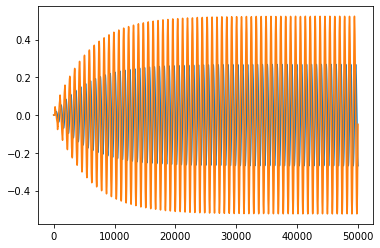

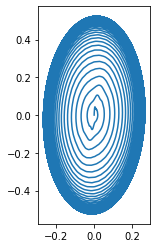

<Figure size 432x288 with 0 Axes>

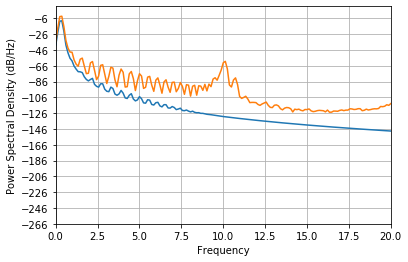

In [81]:
y1, y = D1[0], D[0]
plt.plot(y)
plt.plot(y1)
#plt.plot(res.y[n])

#plt.xlim(30000, 40000)
#plt.xlim(9000, 10000)
plt.figure()
plt.plot(y, y1)

plt.gca().set_aspect('equal')

plt.figure()
#plt.xcorr(y[:1000], y1[:1000])
plt.figure()
_ = plt.psd(y, Fs=fs, NFFT=2**11)
_ = plt.psd(y1, Fs=fs, NFFT=2**11)
plt.xlim(0, 20)
print(sf.get_natural_frequency(1)/(2*np.pi))

In [18]:
Y = A.copy()

In [21]:
class CovSSI(object):
    def __init__(self, Y, order, singular_val_threshold=1e-8):
        self.Y = Y
        self.order = order
        self.singular_val_threshold = singular_val_threshold
    
    def R(self, i):
        l, N = self.Y.shape
        return self.Y[:, :N-i].dot(self.Y[:, i:].T) / (N-i)
    
    def find_block_toeplitz(self, num_blockrows, lag=0):
        l, N = self.Y.shape
        if l*num_blockrows < self.order:
            raise ValueError("The number of block rows must exceed the ratio between order and measurement channels.")
        T = np.zeros((l*num_blockrows, l*num_blockrows))
        for j in range(num_blockrows):
            for k in range(num_blockrows):
                i = num_blockrows + j - k + lag
                T[j*l:(j+1)*l, k*l:(k+1)*l] = self.R(i)
        return T
        
    def compute_state_matrix_NExT_ERA(self, num_blockrows):
        T0 = self.find_block_toeplitz(num_blockrows, 0)
        U0, s0, V0H = np.linalg.svd(T0)
        mask = s0 > self.singular_val_threshold
        U1 = U0[:, mask]
        s1 = s0[mask]
        V1 = V0H[mask].conj().T
        invS1sqrt = np.diag(1/np.sqrt(s1))
        T2 = self.find_block_toeplitz(num_blockrows, 1)
        A = invS1sqrt.dot(U1.T).dot(T2).dot(V1).dot(invS1sqrt)
        return A
    
    def compute_state_matrix_BR(self, num_blockrows):
        l, N = self.Y.shape
        T = self.find_block_toeplitz(num_blockrows, 0)
        U, s, VH = np.linalg.svd(T)
        mask = s > self.singular_val_threshold
        U1 = U[:, mask]
        S1 = np.diag(s[mask])
        O = U1.dot(np.sqrt(S1))
        Oup = O[:-l, :]
        Odwn = O[l:, :]
        print(s.shape, U.shape, O.shape, Oup.shape, Odwn.shape)
        A = np.linalg.lstsq(Oup, Odwn)[0]
        return A
        
    
            

In [22]:
covssi = CovSSI(Y, 20)
SP = covssi.compute_state_matrix_BR(15)
v, q = np.linalg.eig(SP)
r = v
print(np.abs(r))
print([sf.find_natural_frequency(i) / (2*np.pi) for i in range(1, 5)])

(75,) (75, 75) (75, 19) (70, 19) (70, 19)
[0.99700128 0.99700128 0.99705754 0.99705754 0.99767625 0.99767625
 0.9977321  0.9977321  0.99856257 0.99856257 0.99861631 0.99861631
 0.99938691 0.99938691 0.99956163 0.99956163 0.99987522 0.99987522
 0.99482185]
[1.4325187362143874, 4.181502060152035, 6.591724955526461, 8.467925497501913]


C:\Users\Gunnstein\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [39]:
U, s, VH = np.linalg.svd(T)
S = np.diag(s)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


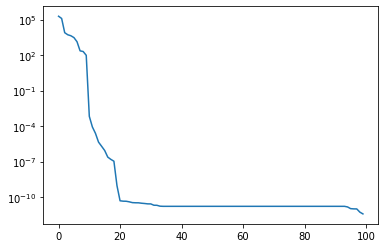

In [36]:
plt.semilogy(s)
print(s>0.)